In [1]:
#This notebook will build a machine learning model to analyze
#microbiome deconstruction within the HCT dataset
#df_deconstruction dataset was generated by looking at patient samples
#that had 3 consecutive decreases in inverse simpson scores 
#within -14 and +21 days of HCT treatment
# S1_S2, D1_D2 , D1_D3 etc ... are delta differences


# # Data Loading

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

In [6]:
df = pd.read_csv('/Users/brian/Documents/2021Spring/Jonas_Rotation/hctmicrobiome/notebooks/df_deconstruction.csv')

In [7]:
#cleaning up df, setting patientID as index, dropping Sample Ids and duplicate column 
df=df.set_index('PatientID')
df=df.drop(['S1_ID', 'S2_ID','S3_ID','Abundant_color'], axis=1)


In [8]:
df.head()

,S1_S2,S2_S3,S1_S3,D1_D2,D2_D3,D1_D3,Abundant,Abundant_S2,Abundant_S3,HexColor_color,S1_score,S2_score,S3_score,S1_Day,S2_Day,S3_Day
PatientID,,,,,,,,,,,,,,,,
1000,7.082404,4.104494,11.186898,5,10,15,Ruminococcaceae,Lactobacillaceae,Lactobacillaceae,#BEA89A,13.289526,6.207122,2.102628,0,5,15
1001,12.277757,0.522479,12.800236,3,13,16,Lachnospiraceae,Erysipelotrichaceae,Enterobacteriaceae,#AD998C,14.795837,2.518080,1.995601,0,3,16
1002,0.084915,0.885212,0.970127,4,4,8,Eubacteriaceae,Lactobacillaceae,Enterococcaceae,#BEA89A,5.394270,5.309356,4.424144,33,37,41
1007,2.183793,7.780397,9.964190,3,7,10,Lachnospiraceae,Lachnospiraceae,Enterococcaceae,#AD998C,11.555565,9.371772,1.591375,0,3,10
1008,4.547695,2.344195,6.891890,5,7,12,Lachnospiraceae,Lachnospiraceae,Acidaminococcaceae,#AD998C,12.777539,8.229844,5.885650,0,5,12


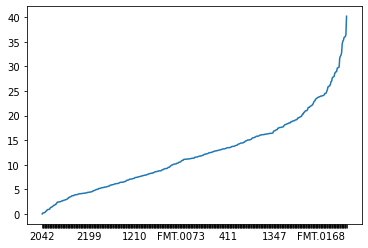

In [5]:


df=df.sort_values(by=['S1_S3'])

plt.plot(df['S1_S3'])
ax = plt.gca()
temp=ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::75]))
for label in temp:
    label.set_visible(False)
plt.show()


## Adding % change as a column


In [6]:
df.columns

Index(['S1_S2', 'S2_S3', 'S1_S3', 'D1_D2', 'D2_D3', 'D1_D3', 'Abundant',
       'Abundant_S2', 'Abundant_S3', 'HexColor_color', 'S1_score', 'S2_score',
       'S3_score', 'S1_Day', 'S2_Day', 'S3_Day'],
      dtype='object')

In [7]:
df['perc_change_S1_S3']=df.apply(lambda x: x['S1_S3']*100/x['S1_score'], axis = 1)
df['perc_change_S1_S2']=df.apply(lambda x: x['S1_S2']*100/x['S1_score'], axis = 1)
df['perc_change_S2_S3']=df.apply(lambda x: x['S2_S3']*100/x['S2_score'], axis = 1)

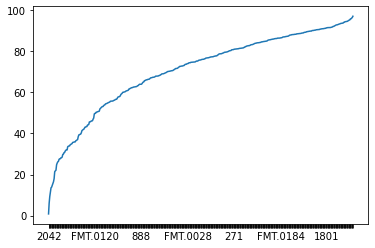

In [8]:

df=df.sort_values(by=['perc_change_S1_S3'])

plt.plot(df['perc_change_S1_S3'])
ax = plt.gca()
temp=ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::75]))
for label in temp:
    label.set_visible(False)
plt.show()



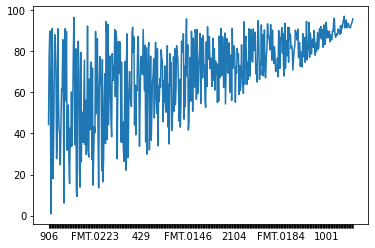

In [9]:
df=df.sort_values(by=['perc_change_S1_S2'])

plt.plot(df['perc_change_S1_S3'])
ax = plt.gca()
temp=ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::75]))
for label in temp:
    label.set_visible(False)
plt.show()

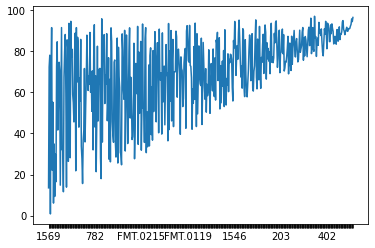

In [10]:
df=df.sort_values(by=['perc_change_S2_S3'])

plt.plot(df['perc_change_S1_S3'])
ax = plt.gca()
temp=ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::75]))
for label in temp:
    label.set_visible(False)
plt.show()

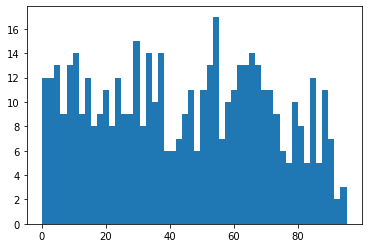

In [11]:
x = df['perc_change_S1_S2']

plt.hist(x, bins=50)
plt.show()

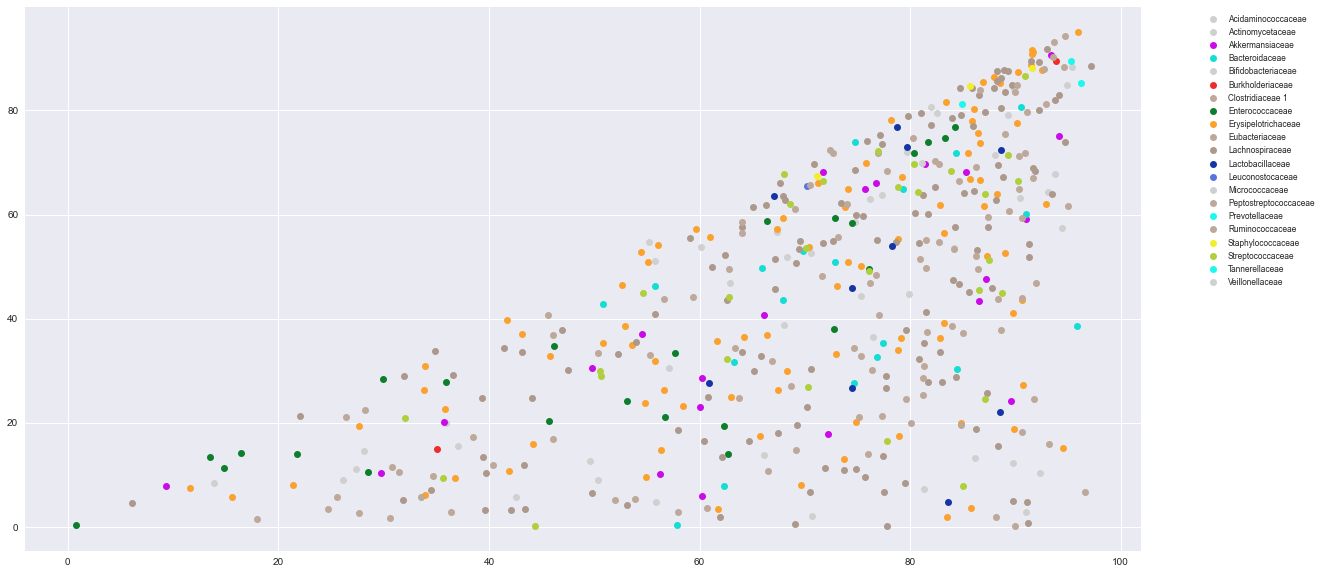

In [12]:

#percen change from S1 to S3 with colors mapped.
#use the colormap

import matplotlib.pyplot as plt
plt.style.use('seaborn')

groups = df.groupby("Abundant")
plt.rcParams["figure.figsize"] = (20,10)
for name, group in groups:
    colors=groups.get_group(name)['HexColor_color'].tolist()
    plt.plot(group["perc_change_S1_S3"],group["perc_change_S1_S2"],color=colors[0],label=name, marker = "o", linestyle="")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')





Text(0, 0.5, 'Percent Change (%)')

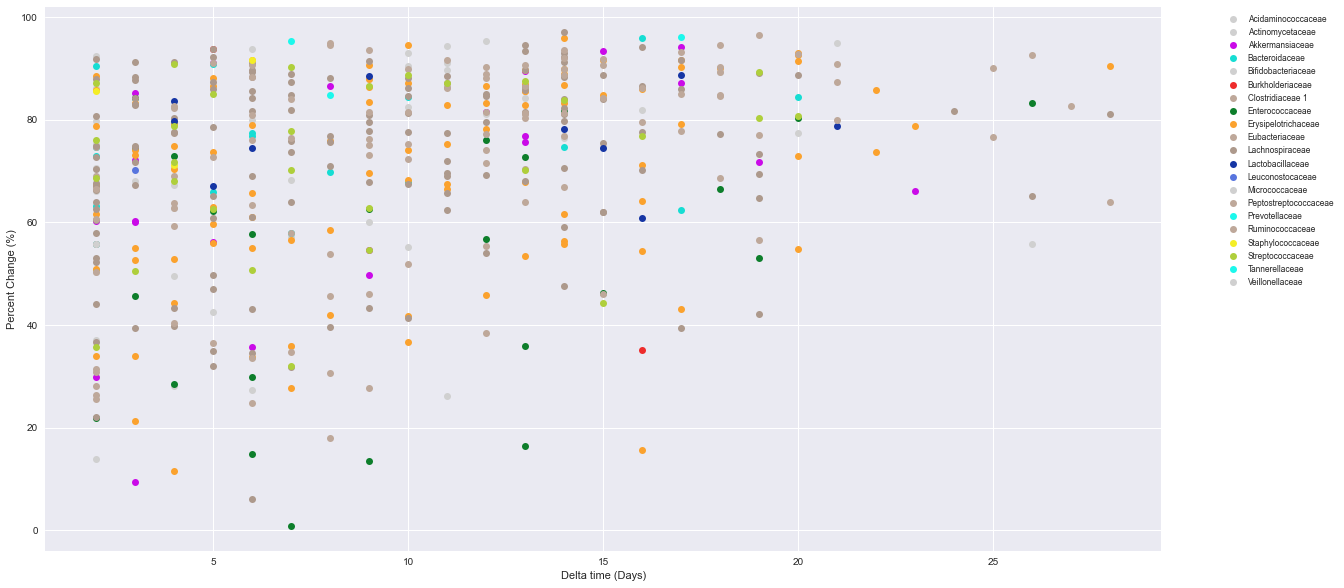

In [13]:
#perc change over delta time
#colored by most abundant bacteria family for S1

#use the colormap

import matplotlib.pyplot as plt
plt.style.use('seaborn')

groups = df.groupby("Abundant")
plt.rcParams["figure.figsize"] = (20,10)
for name, group in groups:
    colors=groups.get_group(name)['HexColor_color'].tolist()
    plt.plot(group["D1_D3"],group["perc_change_S1_S3"],color=colors[0],label=name, marker = "o", linestyle="")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xlabel("Delta time (Days)")
plt.ylabel("Percent Change (%)")



In [14]:
#create abundance dataframe
test=df['Abundant'].value_counts()[:]
test2=df['Abundant_S2'].value_counts()[:]
test3=df['Abundant_S3'].value_counts()[:]
df_abundance=pd.concat([test,test2,test3], axis=1)
df_abundance=df_abundance.fillna(0) #setting na's to zero
df_abundance.head()

,Abundant,Abundant_S2,Abundant_S3
Lachnospiraceae,139.0,88.0,48.0
Erysipelotrichaceae,93.0,100.0,93.0
Ruminococcaceae,64.0,25.0,12.0
Bifidobacteriaceae,37.0,33.0,12.0
Peptostreptococcaceae,33.0,8.0,5.0


<AxesSubplot:>

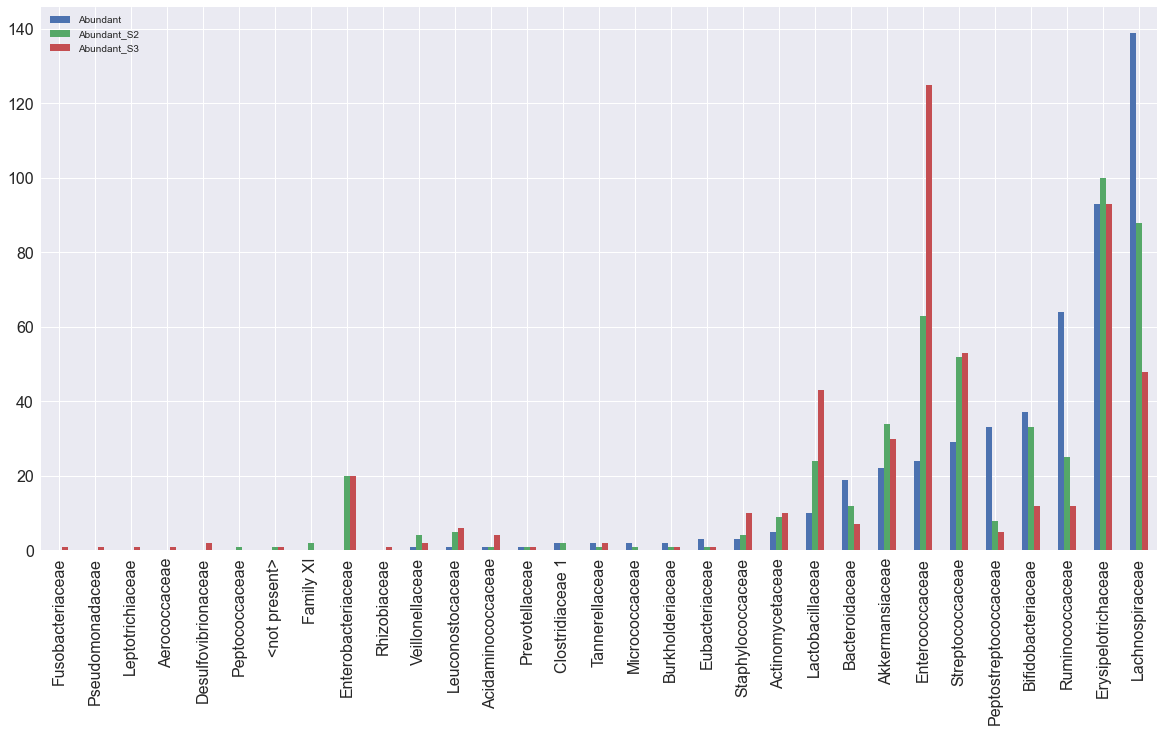

In [15]:
df_abundance.sort_values(by=['Abundant']).plot(kind='bar', fontsize= 16)



# # Kmeans Clustering


In [16]:
df_kmeans=df[['S1_score','S2_score','S3_score']]

In [17]:
# create a kmeans object
kmeans = KMeans(n_clusters = 3)
kmeans.fit(df_kmeans)

KMeans(n_clusters=3)

In [18]:
clusters = kmeans.cluster_centers_
print(clusters)

[[ 9.06489075  4.7524055   2.64414732]
 [19.27217531  9.02006344  4.28568681]
 [29.91229855 19.5029979   9.54196831]]


In [19]:
y_km = kmeans.fit_predict(df_kmeans)

In [20]:
df_kmeans

,S1_score,S2_score,S3_score
PatientID,,,
1569,1.369542,1.185376,1.184679
284,3.726380,1.028632,1.027909
571,17.832274,3.905275,3.895255
2042,1.085802,1.081110,1.077209
1163,28.196365,9.083417,9.028832
...,...,...,...
1390,17.612696,15.780723,1.342537
247,21.275088,17.869525,1.449698
187,26.964595,16.570726,1.113880


In [21]:
df['kmeans_prediction'] = y_km

In [22]:
#saving df to csv

df.to_csv('df_2.csv',index = True)

## visualizing kmeans 

In [23]:
df.head()

,S1_S2,S2_S3,S1_S3,D1_D2,D2_D3,D1_D3,Abundant,Abundant_S2,Abundant_S3,HexColor_color,S1_score,S2_score,S3_score,S1_Day,S2_Day,S3_Day,perc_change_S1_S3,perc_change_S1_S2,perc_change_S2_S3,kmeans_prediction
PatientID,,,,,,,,,,,,,,,,,,,,
1569,0.184166,0.000697,0.184863,7,2,9,Enterococcaceae,Enterococcaceae,Enterococcaceae,#0D7E2B,1.369542,1.185376,1.184679,12,19,21,13.498155,13.447271,0.058790,1
284,2.697748,0.000723,2.698471,3,7,10,Clostridiaceae 1,Enterococcaceae,Enterococcaceae,#BEA89A,3.726380,1.028632,1.027909,0,3,10,72.415341,72.395951,0.070244,1
571,13.926999,0.010020,13.937019,6,6,12,Erysipelotrichaceae,Akkermansiaceae,Erysipelotrichaceae,#FBA22E,17.832274,3.905275,3.895255,0,6,12,78.156153,78.099962,0.256581,2
2042,0.004692,0.003901,0.008593,2,5,7,Enterococcaceae,Enterococcaceae,Enterococcaceae,#0D7E2B,1.085802,1.081110,1.077209,0,2,7,0.791360,0.432095,0.360824,1
1163,19.112947,0.054585,19.167532,3,1,4,Streptococcaceae,Akkermansiaceae,Enterococcaceae,#AFCF3C,28.196365,9.083417,9.028832,0,3,4,67.978736,67.785147,0.600931,0


In [24]:
#subset each cluster into own group 
df_kmeans_0 = df[df['kmeans_prediction'] == 0]
df_kmeans_1 = df[df['kmeans_prediction'] == 1] 
df_kmeans_2 = df[df['kmeans_prediction'] == 2] 

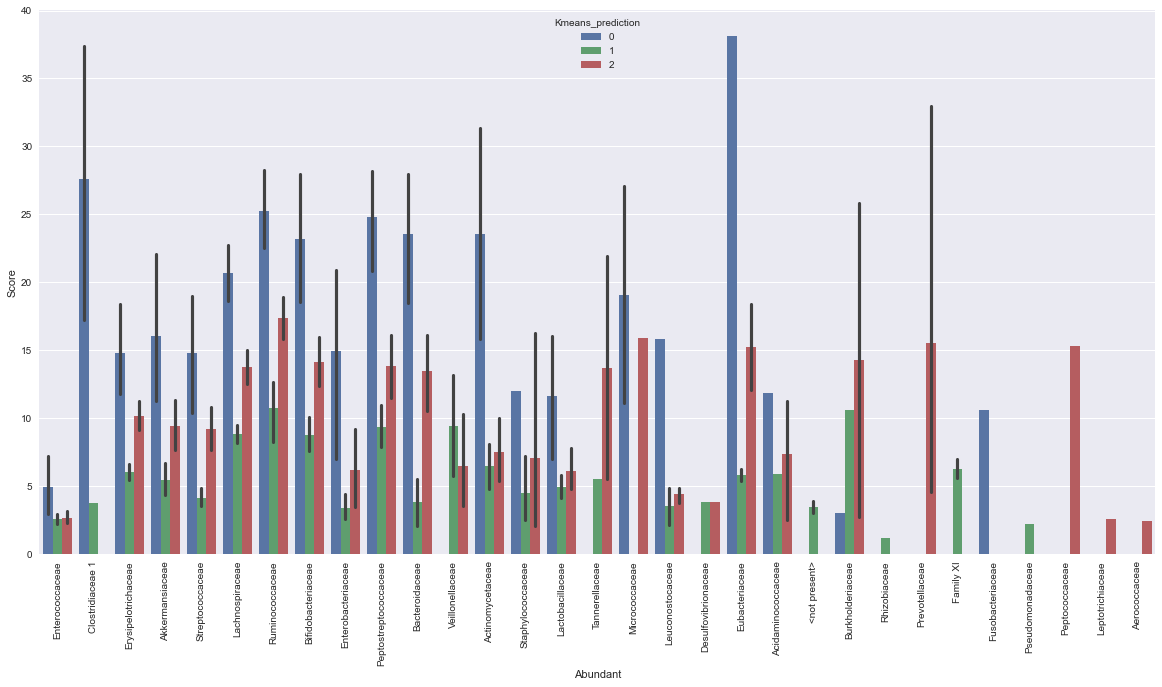

In [25]:
##building a reshaped dataframe for plotting
import seaborn as sns
data=[]
for index, row in df.iterrows():
    data.append([index,'S1',df.loc[[index]]['S1_score'][0],df.loc[[index]]['Abundant'][0],df.loc[[index]]['kmeans_prediction'][0]])
    data.append([index,'S2',df.loc[[index]]['S2_score'][0],df.loc[[index]]['Abundant_S2'][0],df.loc[[index]]['kmeans_prediction'][0]])
    data.append([index,'S3',df.loc[[index]]['S3_score'][0],df.loc[[index]]['Abundant_S3'][0],df.loc[[index]]['kmeans_prediction'][0]])

df_shape=pd.DataFrame(data, columns=['PatientID', 'Type', 'Score','Abundant','Kmeans_prediction'])

#sns.barplot(x="Type", y="Score", data=df_shape, capsize=.1, ci="sd", 
#           hue = "Kmeans_prediction",hue_order=[0,2,1])


sns.barplot(x="Abundant", y="Score", hue = "Kmeans_prediction", data=df_shape)
plt.xticks(rotation=90)
plt.show()

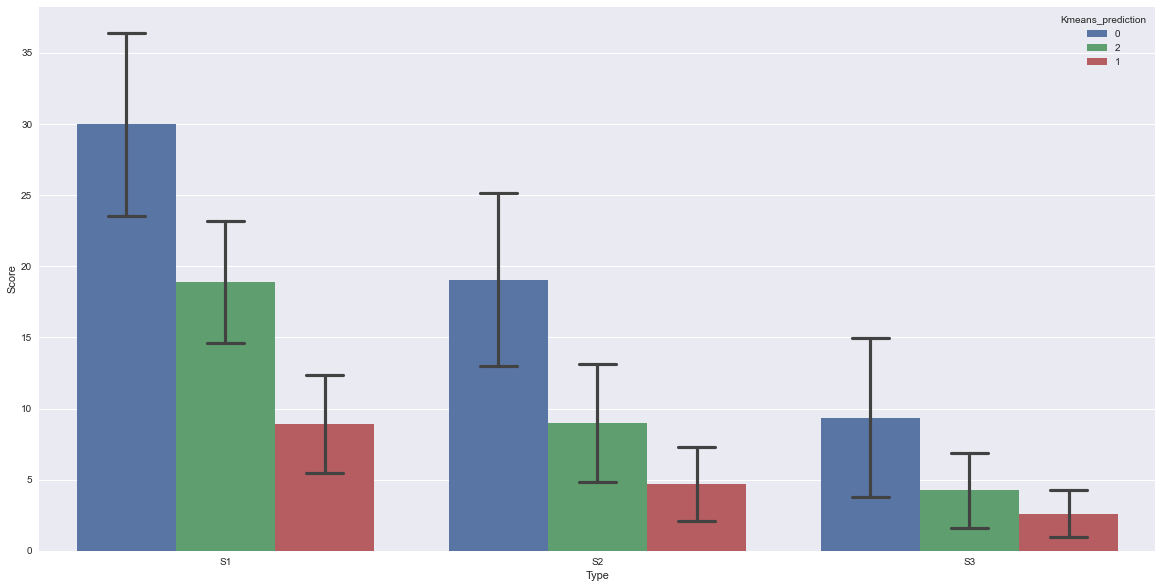

In [26]:
#visualizing kmeans clusters

##kmeans cluster = 0
data=[]
for index, row in df_kmeans_0.iterrows():
    data.append([index,'S1',df.loc[[index]]['S1_score'][0],df.loc[[index]]['Abundant'][0]])
    data.append([index,'S2',df.loc[[index]]['S2_score'][0],df.loc[[index]]['Abundant_S2'][0]])
    data.append([index,'S3',df.loc[[index]]['S3_score'][0],df.loc[[index]]['Abundant_S3'][0]])

df_shape_0=pd.DataFrame(data, columns=['PatientID', 'Type', 'Score','Abundant'])

#kmeans cluster = 1
data=[]
for index, row in df_kmeans_1.iterrows():
    data.append([index,'S1',df.loc[[index]]['S1_score'][0],df.loc[[index]]['Abundant'][0]])
    data.append([index,'S2',df.loc[[index]]['S2_score'][0],df.loc[[index]]['Abundant_S2'][0]])
    data.append([index,'S3',df.loc[[index]]['S3_score'][0],df.loc[[index]]['Abundant_S3'][0]])

df_shape_1=pd.DataFrame(data, columns=['PatientID', 'Type', 'Score','Abundant'])


#kmeans cluster = 2
data=[]
for index, row in df_kmeans_2.iterrows():
    data.append([index,'S1',df.loc[[index]]['S1_score'][0],df.loc[[index]]['Abundant'][0]])
    data.append([index,'S2',df.loc[[index]]['S2_score'][0],df.loc[[index]]['Abundant_S2'][0]])
    data.append([index,'S3',df.loc[[index]]['S3_score'][0],df.loc[[index]]['Abundant_S3'][0]])

df_shape_2=pd.DataFrame(data, columns=['PatientID', 'Type', 'Score','Abundant'])


sns.barplot(x="Type", y="Score", data=df_shape, capsize=.1, ci="sd", 
            hue = "Kmeans_prediction",hue_order=[0,2,1])


#sns.swarmplot(x="Type", y="Score", data=df_shape_0, color="0", alpha=.35)

#sns.swarmplot(x="Type", y="Score", data=df_shape_1, color="0.5", alpha=.35)
#sns.swarmplot(x="Type", y="Score", data=df_shape_2, color="1", alpha=.35)

plt.show()

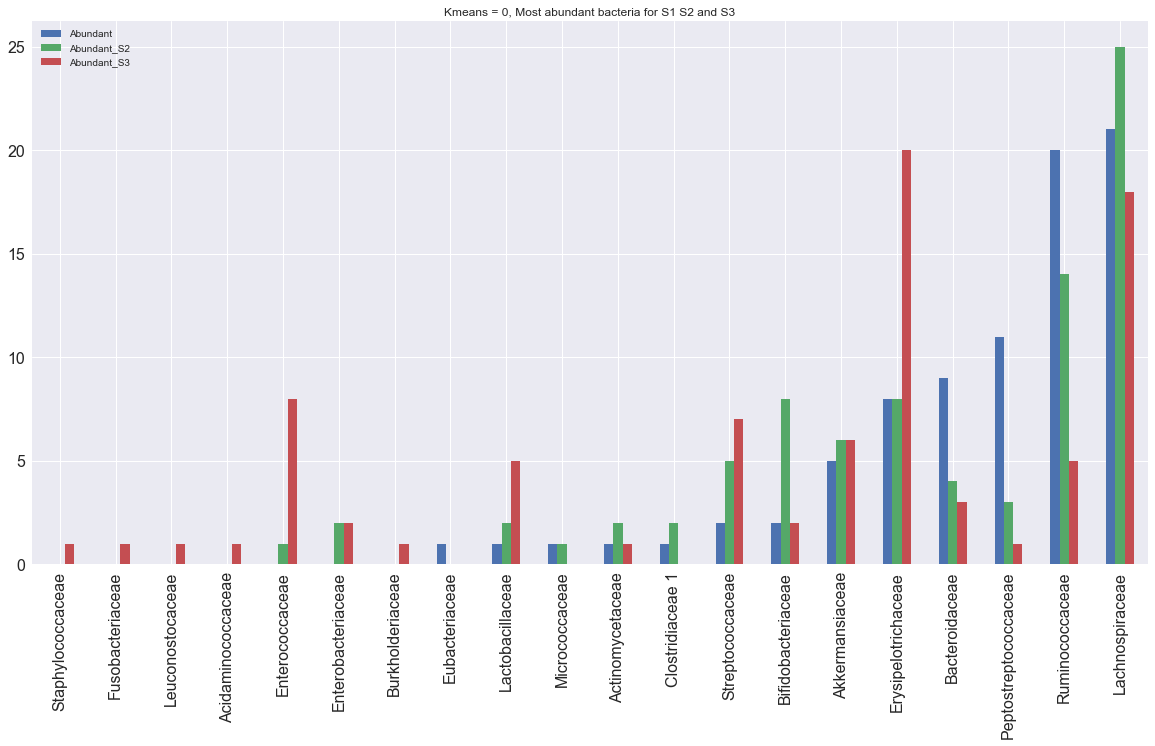

In [27]:
#plotting abundance bargraph but subset by kmeans clustering 

#create abundance dataframe 
test = df_kmeans_0['Abundant'].value_counts()[:]
test2 = df_kmeans_0['Abundant_S2'].value_counts()[:]
test3 = df_kmeans_0['Abundant_S3'].value_counts()[:]
df_abundance_k0 = pd.concat([test,test2,test3], axis=1)
df_abundance_k0 = df_abundance_k0.fillna(0) #setting na's to zero
df_abundance_k0.sort_values(by=['Abundant']).plot(kind='bar', fontsize= 16)
plt.title('Kmeans = 0, Most abundant bacteria for S1 S2 and S3')
plt.show()



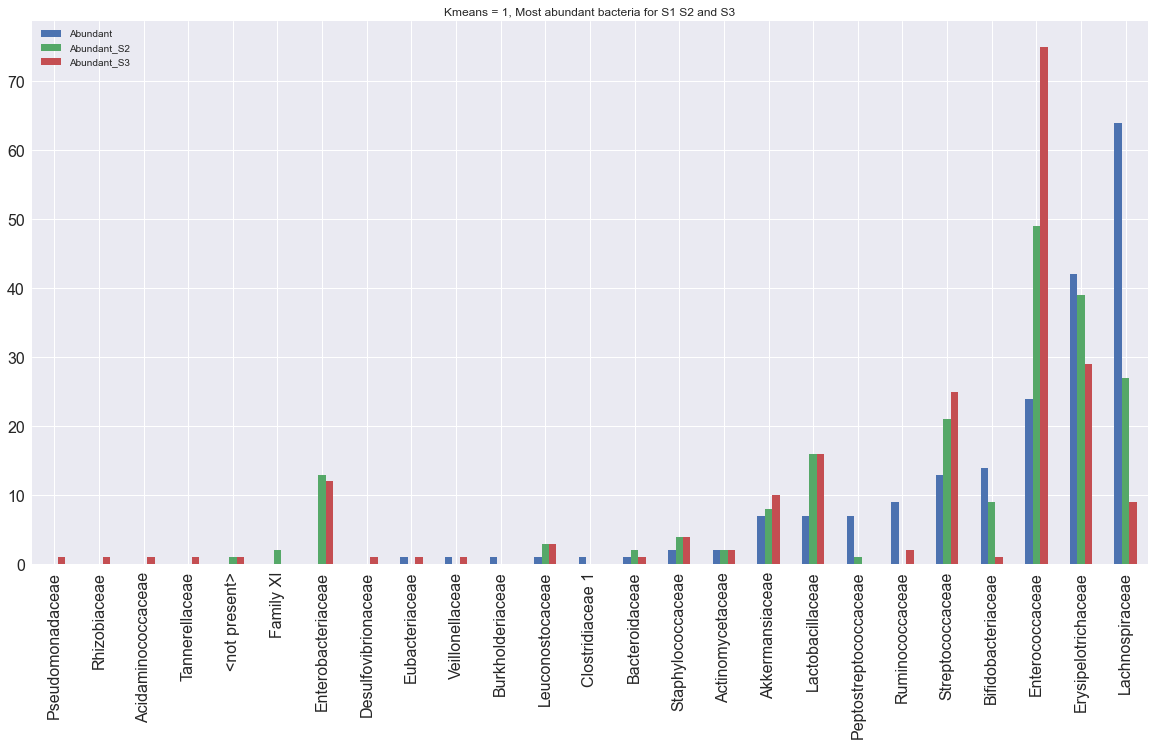

In [28]:

test = df_kmeans_1['Abundant'].value_counts()[:]
test2 = df_kmeans_1['Abundant_S2'].value_counts()[:]
test3 = df_kmeans_1['Abundant_S3'].value_counts()[:]
df_abundance_k1 = pd.concat([test,test2,test3], axis=1)
df_abundance_k1 = df_abundance_k1.fillna(0) #setting na's to zero
df_abundance_k1.sort_values(by=['Abundant']).plot(kind='bar', fontsize= 16)
plt.title('Kmeans = 1, Most abundant bacteria for S1 S2 and S3')
plt.show()



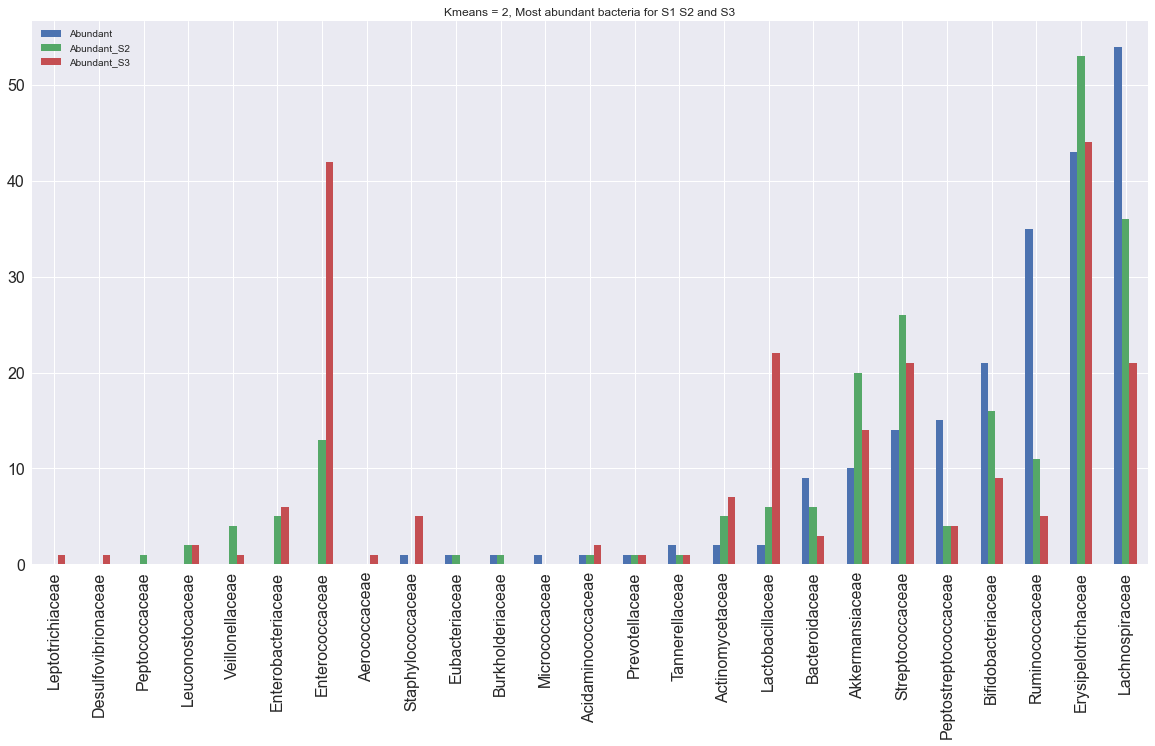

In [29]:

test = df_kmeans_2['Abundant'].value_counts()[:]
test2 = df_kmeans_2['Abundant_S2'].value_counts()[:]
test3 = df_kmeans_2['Abundant_S3'].value_counts()[:]
df_abundance_k2 = pd.concat([test,test2,test3], axis=1)
df_abundance_k2 = df_abundance_k2.fillna(0) #setting na's to zero
df_abundance_k2.sort_values(by=['Abundant']).plot(kind='bar', fontsize= 16)
plt.title('Kmeans = 2, Most abundant bacteria for S1 S2 and S3')
plt.show()